In [22]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# A

In [23]:
ColorImg = glob.glob("apples/*.jpg")
ColorImgs = []
for myFile in ColorImg:
    im = plt.imread(myFile)
    ColorImgs.append(im/255) # normalize the image

    
MaskImg = glob.glob("apples/*.png")
MaskImgs = []
for myFile in MaskImg:
    im = plt.imread(myFile)
    MaskImgs.append(im[:,:,1]) # get binary values

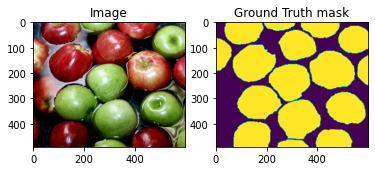

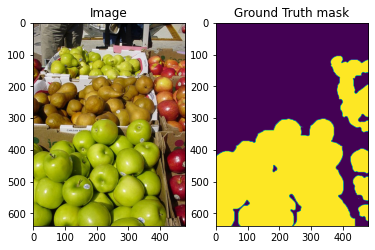

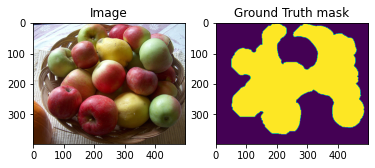

In [24]:
# plot the test image and the ground truth mask for training plots      
for i in range(len(ColorImgs)):    
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(ColorImgs[i])
    ax1.set_title('Image')
    ax2.imshow(MaskImgs[i])
    ax2.set_title('Ground Truth mask')
    
plt.show()

In [25]:
# create lists for apple and non-apple pixels as our training dataset
apple_pixel = []
non_apple_pixel = [] 

for k in range(len(MaskImgs)):
    for i in range(MaskImgs[k].shape[0]):
        for j in range(MaskImgs[k].shape[1]):
            # decide the pixel belongs to which list
            # split them into Apples pixels and nonApples pixels
            if MaskImgs[k][i, j] == 0:
                non_apple_pixel.append(ColorImgs[k][i,j,:])
            else:
                apple_pixel.append(ColorImgs[k][i,j,:])

Apples = np.asarray(apple_pixel).T  
nonApples = np.asarray(non_apple_pixel).T 

In [26]:
print(Apples.shape)  
print(nonApples.shape)

(3, 429649)
(3, 370651)


# B

In [27]:
def calcGaussianProb(data,gaussMean,gaussCov):
    diff = data - gaussMean[:,None] 
    numerator = (-1/2) * np.sum((np.dot(diff.T,np.linalg.pinv(gaussCov))*diff.T),axis=1) # diff.T@inv(cov)@diff.T
    denominator = np.linalg.det(2 * np.pi * gaussCov)**(1/2)
    like = np.exp(numerator) / denominator 
    return like

In [28]:
def MixGauss_like_loglike(data, mixGaussEst,log = True):
    # calculate likelihood (a vector) used for Q(c)
    # calculate log likelihood (a scalar) used for stopping iterations in fitMixGauss
    nDims, nData = data.shape
    like = np.zeros((nData, ))  
    for k in range(mixGaussEst['k']): 
        like += mixGaussEst['weight'][k]*calcGaussianProb(data,mixGaussEst['mean'][:,k],mixGaussEst['cov'][:, :,k])
    if log == True:
        Like = sum(np.log(like)) 
    else:
        Like = like
        
    return Like

In [29]:
def fitMixGauss(data, k):   

    """
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    """
    nDims, nData = data.shape                                                                                        
                                                                                                                     
                                                                                                      
    responsibility = np.zeros(shape=(k, nData))                                                                    
                                                                                                                     
    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
    
    # get the current loglike
    log_initial = MixGauss_like_loglike(data, mixGaussEst)
    log_Like = []
    log_Like.append(log_initial)
    
    nIter = 100
     
    
    for cIter in range(nIter):
        
        # ===================== =====================
        # Expectation step
        # ===================== =====================  
            
        for i in range(mixGaussEst['k']):
            responsibility[i] = mixGaussEst['weight'][i]*calcGaussianProb(data,mixGaussEst['mean'][:,i], mixGaussEst['cov'][:,:,i])
        
        responsibility = responsibility/np.sum(responsibility, axis=0)

        # ===================== =====================
        # Maximization Step
        # ===================== ===================== 
                                                                            
        for cGauss in range(k):                                                                                      
            # TO DO:  Update weighting parameters mixGauss.weight based on the total                                 
            # posterior probability associated with each Gaussian. Replace this:                                         
            mixGaussEst['weight'][cGauss] = np.sum(responsibility[cGauss, :])/np.sum(responsibility)
            # lamda_k = sum_i(r_ik)/sum(r_ij)
                                                                                                                 
            # TO DO:  Update mean parameters mixGauss.mean by weighted average                                       
            # where weights are given by posterior probability associated with                                       
            # Gaussian.  Replace this:                                    
            mixGaussEst['mean'][:,cGauss] = responsibility[cGauss,:].reshape(1,nData) @ data.T /np.sum(responsibility[cGauss, :])
            # mu_k = sum_i(r_ik*x_i)/sum_i(r_ik)
            
            # TO DO:  Update covarance parameter based on weighted average of                                        
            # square distance from update mean, where weights are given by                                           
            # posterior probability associated with Gaussian  
            # diff = X_i - mu_k
            diff = data - mixGaussEst['mean'][:,cGauss][:,None]
            mixGaussEst['cov'][:,:,cGauss] = responsibility[cGauss]*diff@diff.T / np.sum(responsibility[cGauss, :])
            # cov_k = sum_i(rik*diff*diff.T)/sum_i(r_ik)
       
    
        log_like = MixGauss_like_loglike(data, mixGaussEst)
        log_Like.append(log_like)
        # Here i add a stopping rule. When the log likes becomes stable
        # it means we can stop training the model
        if(abs(log_Like[cIter] - log_Like[cIter+1]) < 1):
             break
        else:
             continue
                                                                                                                  
    return mixGaussEst,log_Like 

In [30]:
# use k = 3
appleMixGaussEst,apple_log_like = fitMixGauss(Apples,3)
nonAppleMixGaussEst,nonApple_log_like = fitMixGauss(nonApples,3)

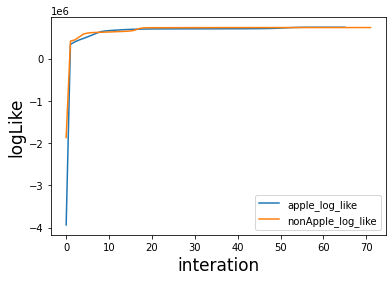

In [31]:
plt.plot(apple_log_like, label= 'apple_log_like')
plt.plot(nonApple_log_like, label= 'nonApple_log_like')
plt.legend()
plt.xlabel('interation', fontsize=17)
plt.ylabel('logLike', fontsize=17)
plt.show()

#### Comments and Improvement: 
From the plot above, we see the nonApple log likelihood did not converge within 100 interation since the curve did not end at 100 iteration, we might try more times to imporve our model. After training, we see the loglikes become stable after about 20 interations for both nonApple and apple.

I use k = 3, which means three Gaussians mixture model. 
Possible improvement: try k = 4. k cannot be very big or very small value, becasue it might cause overfitting or underfitting problems.

# C

In [32]:
TestImg = glob.glob("testApples/*.jpg")
TestImgs = []
for myFile in TestImg:
    im = plt.imread(myFile)
    TestImgs.append(im/255) # normalize the image

In [33]:
def posterior_prob(image,priorApple,priorNonApple):
    posteriorApple = []
    for i in range(len(image)):
        im = image[i]  # for each image
        imY, imX, imZ = im.shape
        img = im.reshape(imY*imX,imZ).T # convert it to shape(3(imZ), total pixels)
        # calculate MixGauss_like
        likeApple = MixGauss_like_loglike(img, appleMixGaussEst,log = False)
        likeNonApple = MixGauss_like_loglike(img, nonAppleMixGaussEst,log = False)
        # convert posterior back to shape(imY, imX)
        posterior = ((likeApple*priorApple)/(likeApple*priorApple+likeNonApple*priorNonApple)).reshape(imY, imX)
        posteriorApple.append(posterior)
            
    return posteriorApple

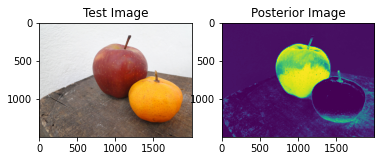

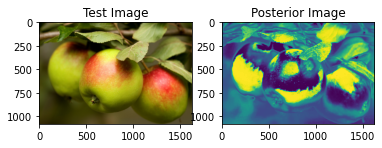

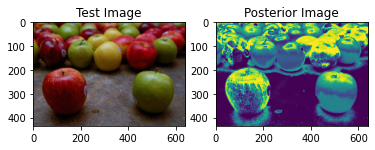

In [34]:
# Calculate prior 
# The prior is calculated by counting the number of data in positive dataset.
priorApple = Apples.shape[1]/(nonApples.shape[1]+Apples.shape[1])
priorNonApple = 1 - priorApple
posteriorApple = posterior_prob(TestImgs,priorApple,priorNonApple)


for i in range(len(TestImgs)):
# display the test image and the posterior image
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(TestImgs[i])
    ax1.set_title('Test Image')
    ax2.imshow(posteriorApple[i])
    ax2.set_title('Posterior Image')
    
plt.show()

#### Comments and Improvement: 
From the plots above, we see the posterior images for each apple picture. The yellow part is the apple pixels (high probability) and the dark part is the nonapple pixels(low probability). The model roughly detects the apple and nonapple pixels. But my model cannot detect the apple under shadow(third plot) the green apples(third plot), the yellow apples(third plot) or the red and green part of the apple(second plot).

Improvement: might choose more types of apples picture to train. Or introducing some deep learning techniques to capture the relations among different apple pixels.

# D

In [35]:
TestMask = glob.glob("testApples/*.png")
TestMasks = []
for myFile in TestMask:
    im = plt.imread(myFile)
    TestMasks.append(im[:,:,1]) # get binary values

In [36]:
def ROC_curve(posterior,mask,threshold_size):
    threshold = np.arange(0,1,threshold_size) # a range of threshold
    FPR = [] # false positive rate = 1 - TN/(FP+TN) = FP/(FP+TN)
    TPR = [] # true positive rate = TP/(TP+FN)
    D,N = posterior.shape
    
    for i in threshold:
        # define intial counts
        TP = 0 # True Positives (TP): is apple and recognized as apple
        TN = 0 # True Negatives (TN): is not apple and recognized as not apple
        FP = 0 # False Positives (FP): is apple and recognized as not apple
        FN = 0 # False Negatives (FN): is not apple and recognized as apple
            
        for d in range(D):  
            for j in range(N):        
                if((mask[d,j] == 1) and (posterior[d,j] >= i)):
                    TP += 1
                elif ((mask[d,j] == 0) and (posterior[d,j] < i)):
                    TN += 1                    
                elif ((mask[d,j] == 1) and (posterior[d,j] < i)):
                    FP += 1
                elif ((mask[d,j] == 0) and (posterior[d,j] >= i)):
                    FN += 1

        # consider the situation denominator = 0
        if (FP+TN == 0):
            fpr = 0
        else:
            fpr = FP/(FP+TN)
            
            
        if (TP+FN == 0):
            tpr = 0
        else:
            tpr = TP/(TP+FN)
            
        FPR.append(fpr)
        TPR.append(tpr)
    
    return FPR, TPR


Text(0.5, 1.0, 'Posterior Image')

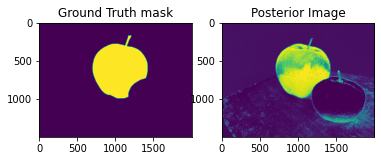

In [37]:
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(TestMasks[0])
ax1.set_title('Ground Truth mask')
ax2.imshow(posteriorApple[0])
ax2.set_title('Posterior Image')

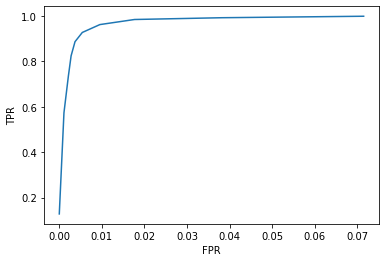

In [38]:
FPR, TPR = ROC_curve(posteriorApple[0],TestMasks[0],0.1)
plt.plot(FPR, TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Comments: 
From definition, we know the ROC curve closer to the upper left corner(0,1), the better the performance of the model.
From the plots above, we see ROC curve behaves well. This means the classifier has a very low false positive rate and a high true positive rate at the same time.

# E

In [39]:
ValidImg = glob.glob("myApples/*.jpg")
ValidImgs = []
for myFile in ValidImg:
    im = plt.imread(myFile)
    ValidImgs.append(im/255) # normalize the image

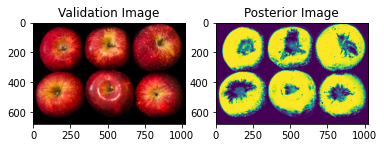

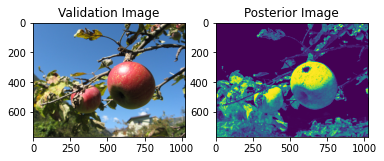

In [40]:
posteriorApple_valid = posterior_prob(ValidImgs,priorApple,priorNonApple)
for i in range(len(ValidImgs)):
# display the test image and the posterior image
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(ValidImgs[i])
    ax1.set_title('Validation Image')
    ax2.imshow(posteriorApple_valid[i])
    ax2.set_title('Posterior Image')
    
plt.show()

#### Comments: 
From the plots above, we see the posterior images for ValidImgs. But it has similar problem as above. The shadow part and the yellow and red part on the apple cannot be detected perfectly. This time it also cannot detect the highlight part(second picture, there is a 'hole' on the bigger apple).

In [22]:
ValidMask = glob.glob("myApples/*.PNG")
ValidMasks = []
for myFile in ValidMask:
    im = plt.imread(myFile)
    ValidMasks.append(im[:,:,1]) # get binary values

Text(0.5, 1.0, 'Posterior Image')

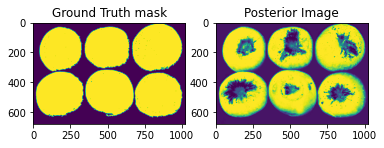

In [23]:
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(ValidMasks[0])
ax1.set_title('Ground Truth mask')
ax2.imshow(posteriorApple_valid[0])
ax2.set_title('Posterior Image')

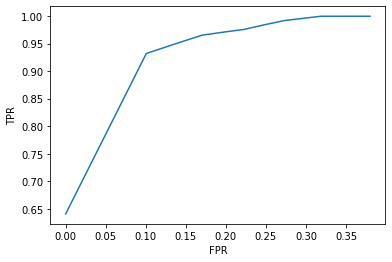

In [24]:
FPR, TPR = ROC_curve(posteriorApple_valid[0],ValidMasks[0],0.1)
plt.plot(FPR, TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

Text(0.5, 1.0, 'Posterior Image')

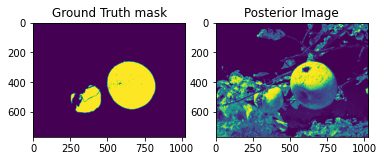

In [25]:
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(ValidMasks[1])
ax1.set_title('Ground Truth mask')
ax2.imshow(posteriorApple_valid[1])
ax2.set_title('Posterior Image')

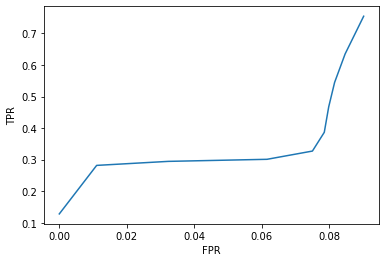

In [26]:
FPR, TPR = ROC_curve(posteriorApple_valid[1],ValidMasks[1],0.1)
plt.plot(FPR, TPR)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Comments and Improvement: 
From the ROC curves above, the model performs good on the two validation apple pictures because the ROC curves are closed to the point (0,1).

Imporvement: It might be helpful to change k or use more interations and pictures to train. And then we use the validation apple pictures to decide which k or model is better.

# F

#### Q: We should really be using three separate sets of files: a training set, a validation set, and a test set! Explain why.

A: The training set is used to train our model and get the parameters. Since we know nothing about our model, we have to use some new data to train the model. We usually choose 80% data to train.
   
To test the performance of the model, we usually use the other 20% data to test. We can find if the model learned from training sets performs well on test sets. If not, change the model or parameters.
   
The validation set can often check the overfitting or underfitting problems of our model. If we have a model performing well on test sets but bad on validation set, we would better adjust our model. The validation set is also used to compare different models. When we cannot decide which one is better, validation set helps to find the best estimates and models.
   
Here, I first used trainApples to train our model. Then I used testApples to evaluate the performance of my model, which gives a good performance (seen from ROC curve). When I used myApples as the validation set, I got a good performance on that set (seen from ROC curve). But our model still cannot detect apple under shadow or apple with other colors(e.g. green, yellow, yellow and red, green ans red). To imporve my model, I can use more apple pictures to train. Also I can further try other paramenters and test on the validation set again. Usually, we use cross-validation to train the model several times in order to get the 'best' model. 